# Prediction de masse ou prediction de flux

### For this part, I propose to reuse the great notebook proposed by Matthew Ho, Francois Lanusse that illlustrates how to use a Neureal Network to predict the mass of dark matter halos from other parameters in a simulation.

We will only cover the first part of their more cpmplete tutorial, focusing on building a simple neural network for demonstration purpose. Their complete example goes into the details of biases that may arise with such method and how to extend this idea with Bayesian reasoning.

The original notebook can be found here : https://colab.research.google.com/drive/1A9wG9UVIRbWjxtM5XzDO3Sqc-aY5TzLJ?usp=sharing#scrollTo=jIKPkpeOR3-D

##### Copyright 2019-2022 Matthew Ho, Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Estimating Galaxy Cluster Masses with JAX

Authors:
  - [@maho3](https://github.com/maho3) (Matt Ho)
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)

with small modifications from Florian Sarron

### Overview

In this tutorial, we learn how to build a neural network using JAX and the Flax library to estimate the masses of galaxy clusters using velocity dispersion measurements. See for instance [Ho et al. (2019)](https://arxiv.org/abs/1902.05950) for a detailed introduction of this problem and for an example of a machine learning approach.

The context for this problem is to be able to build robust mass estimates for
galaxy clusters, simply by using information from their galaxy members. And in particular line of sight velocity information which can be obtained by spectroscopy.

As we will see, despite combining a number of input features, the model prediction always has some uncertainties. The original notebook by Ho & Lanusse highlights this point and show it is important to properly account for them to avoid biasing results.

### Learning objectives (In this shorten vesion)

In this notebook, we will learn:
*   How to build and train a neural network with JAX/Flax.

In [ ]:
#@title Imports and Utility functions { display-mode: "form" }
!pip install --quiet flax
%pylab inline

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions


def binned_plot(X, Y, n=10, percentiles=[35, 50], ax=None, label=None, **kwargs):
    # Calculation
    calc_percent = []
    for p in percentiles:
        if p < 50:
            calc_percent.append(50-p)
            calc_percent.append(50+p)
        elif p == 50:
            calc_percent.append(50)
        else:
            raise Exception('Percentile > 50')

    bin_edges = np.linspace(X.min()*0.9999, X.max()*1.0001, n+1)

    dtype = [(str(i), 'f') for i in calc_percent]
    bin_data = np.zeros(shape=(n,), dtype=dtype)

    for i in range(n):
        y = Y[(X >= bin_edges[i]) & (X < bin_edges[i+1])]

        if len(y) == 0:
            continue

        y_p = np.percentile(y, calc_percent)

        bin_data[i] = tuple(y_p)

    # Plotting
    if ax is None:
        f, ax = plt.subplots()

    bin_centers = [np.mean(bin_edges[i:i+2]) for i in range(n)]
    for p in percentiles:
        if p == 50:
            ax.plot(bin_centers, bin_data[str(p)], label=label, **kwargs)
        else:
            ax.fill_between(bin_centers,
                            bin_data[str(50-p)],
                            bin_data[str(50+p)],
                            alpha=0.2,
                            **kwargs)

    return bin_data, bin_edges


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#@title Loading dataset.
#from google.colab import auth
from astropy.table import Table

#auth.authenticate_user()
bucket_name='ahw2019'

!gsutil cp gs://{bucket_name}/halo_mass_regression/'Rockstar_UM_z=0.117_contam_summary.fits' contam_summary.fits

print('Download complete')

data = Table.read('contam_summary.fits')

Copying gs://ahw2019/halo_mass_regression/Rockstar_UM_z=0.117_contam_summary.fits...
- [1 files][ 59.8 MiB/ 59.8 MiB]                                                
Operation completed over 1 objects/59.8 MiB.                                     
Download complete


Once loaded, our entire dataset is contained in the following astropy table:

In [ ]:
data

col0,rockstarId,Mvir,Rvir,Rs,Macc,Vacc,M500c,M200c,x,y,z,vx,vy,vz,rotation,Ngal,sigv,R_mean,R_std,R_skew,R_kurt,m_mean,m_std,m_skew,m_kurt,v_mean,v_std,v_skew,v_kurt
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,11876493031.0,35145000000000.0,694.862,56.20399999999999,35145000000000.0,634.77,26808000000000.0,31623000000000.0,454.79699999999997,46.6157,513.582,136.12,229.27,559.81,0.0,12,736.618121710817,0.48166394,0.34098077,1.7026845,2.3296638,33043448000.0,61462827000.0,2.9122076,6.7132716,-41.345745,705.2582,1.1430991,0.17902263
1,11873794824.0,37972000000000.0,713.015,119.139,37972000000000.0,550.9,23174000000000.0,31624000000000.0,349.36800000000005,699.627,725.3610000000001,447.93,27.27,-325.94,0.0,15,656.621053150712,0.23091273,0.1384827,1.0088234,0.5262666,28882317000.0,31812958000.0,1.2545568,0.1842026,-83.58196,634.3562,-2.2571876,5.1424093
2,11845747573.0,36989000000000.0,706.808,97.24700000000001,36989000000000.0,568.18,22819000000000.0,31624000000000.0,147.344,641.366,401.904,-503.16,-173.39,-76.67,0.0,14,352.14863685716153,0.40480524,0.34237957,2.3846564,5.5665827,20052520000.0,21794046000.0,1.6818756,1.5856993,-159.49951,339.33893,0.014397563,-0.38674146
3,11829717221.0,36967000000000.0,706.665,111.266,36967000000000.0,552.48,23341000000000.0,31626000000000.0,39.5524,872.8889999999999,282.846,211.51,533.94,-187.31,0.0,44,445.92832873349295,0.72628635,0.37803993,-0.17472617,-1.2548987,27312960000.0,30375268000.0,1.6552553,2.2626326,31.216814,440.83185,-0.38536417,0.13803148
4,11894887828.0,42373000000000.0,739.557,164.11599999999999,42373000000000.0,579.75,20478000000000.0,31626000000000.0,574.8009999999999,43.5476,914.015,152.54,-956.44,536.98,0.0,30,576.7330455548778,0.6359491,0.4102169,0.52388453,-0.1262508,46708896000.0,48026330000.0,1.0919354,-0.021746904,-18.416805,567.03937,-0.10975955,-0.84095424
5,11920830717.0,39226000000000.0,720.779,110.13,39226000000000.0,569.81,22682000000000.0,31627000000000.0,708.8660000000001,963.385,279.418,25.18,257.25,283.99,0.0,50,837.0190654972694,0.7849868,0.35027495,0.44492412,-0.52871865,23442210000.0,28291217000.0,1.9385648,3.1598203,-161.50522,828.6066,1.3652864,0.91908824
6,11931054778.0,37545000000000.0,710.329,134.393,37545000000000.0,535.13,20388000000000.0,31627000000000.0,859.45,89.2224,550.524,46.04,-387.17,122.98,0.0,14,253.95280856836953,0.44603017,0.33864185,1.2175168,1.4111,26649532000.0,29983664000.0,1.2680459,0.13279766,-63.58236,244.71504,-0.256204,-1.1912211
7,11868133651.0,39183000000000.0,720.512,244.521,39183000000000.0,524.57,17845000000000.0,31627000000000.0,356.76599999999996,98.2121,787.9110000000001,289.32,154.79,165.95,0.0,20,357.55218150574643,0.7514472,0.63178635,0.19697906,-1.7800003,30875474000.0,28542585000.0,1.9028373,2.6522446,-52.24524,348.49875,0.27920347,-0.2999073
8,11897671903.0,37637000000000.0,710.908,108.181,37637000000000.0,558.72,22923000000000.0,31627000000000.0,579.2909999999999,330.587,886.3919999999999,-645.41,26.33,789.02,0.0,19,372.24322024158505,0.81707364,0.5326949,-0.117305174,-1.7025138,34664415000.0,37983890000.0,1.558092,1.5819969,-28.01323,362.31494,0.22940758,-0.80751944


These columns correspond to outputs of the rockstar halo finder, the quantity of interest that we will attempt to predict from other properties is the `M200c` halo mass.

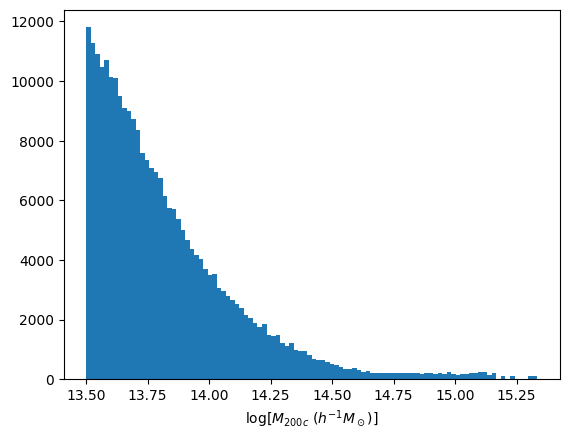

In [ ]:
# Let's check the mass distribution in this sample
hist(log10(data['M200c']),100)
xlabel(r'$\log[M_{200c}\ (h^{-1}M_\odot)]$');

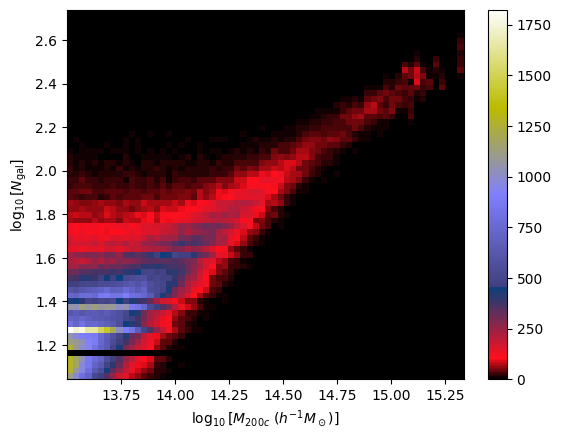

In [ ]:
hist2d(log10(data['M200c']), log10(data['Ngal']),64,cmap='gist_stern');
plt.colorbar()
xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')
ylabel(r'$\log_{10}[N_\mathrm{gal}]$');

This plot shows the scaling relation between mass and number of cluster
members

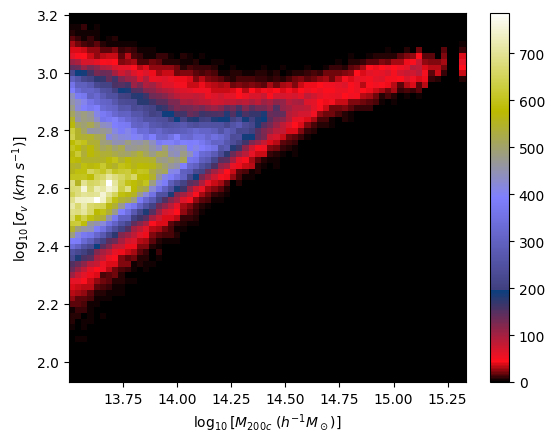

In [ ]:
hist2d(log10(data['M200c']), log10(data['sigv']),64,cmap='gist_stern');
plt.colorbar()
xlabel(r'$\log_{10}[M_{200c}\ (h^{-1}M_\odot)]$')
ylabel(r'$\log_{10}[\sigma_v\ (km\ s^{-1})]$');

This plot illustrates the scaling relation between mass and the velocity dispersion of cluster members.

Now let's do a bit of preprocessing to prepare training data.

In [ ]:
# Preprocessing some features
data['LogNgal'] = np.log10(data['Ngal'])
data['Logsigv'] = np.log10(data['sigv'])
data['logmass'] = np.log10(data['M200c'])

# Preparing data set
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Split into train and test
inds_random = permutation(len(data))
data_train = data[inds_random[:200000]]
data_test = data[inds_random[200000:]]

# Features to use for regression
X = data[['LogNgal', # log richness
          'Logsigv', # log velocity dispersion
          'R_mean', 'R_std', 'R_skew', 'R_kurt', # descriptive features of cluster member projected radius distribution
          'm_mean', 'm_std', 'm_skew', 'm_kurt', # " of member stellar mass distribution
          'v_mean', 'v_std', 'v_skew', 'v_kurt'  # " of member LOS velocity distribution
         ]].to_pandas().values

X_train = X[inds_random[:200000]]
X_test = X[inds_random[200000:]]

scaler = MinMaxScaler().fit(data['logmass'].reshape((-1,1)))
feature_scaler = StandardScaler().fit(X_train)

X_train = feature_scaler.transform(X_train)
Y_train = np.clip(scaler.transform(data_train['logmass'].reshape((-1,1))), 1e-5,1-1e-5)

X_test = feature_scaler.transform(X_test)
Y_test = np.clip(scaler.transform(data_test['logmass'].reshape((-1,1))),1e-5,1-1e-5)

Y_true = data_test['logmass']

In [ ]:
# Last thing we need is a function that will return random batches of training data
def get_batch(batch_size=128):
  indices = np.random.choice(len(X_train), size=128) # This samples with replacement
  # Get a new batch of data
  x = X_train[indices]
  y = Y_train[indices]
  return x, y

## First approach: Building a regression model in JAX/Flax

We begin by implementing a simple regression model using a mean squared error loss. This is the standard approach taken by most ML papers on this problem.


In [ ]:
import flax.linen as nn
from flax.metrics import tensorboard
import optax

In [ ]:
class MLP(nn.Module):
  @nn.compact
  def __call__(self, x):
      # Implement a simple 3 layers Perceptron, that should return just one number
    # A good choice would be 2 dense layers with relu activation, of size 128
    # here is what it layer looks like
    x = nn.relu(nn.Dense(128)(x))
    x = nn.relu(nn.Dense(128)(x))
    x = nn.tanh(nn.Dense(64)(x))
    x = nn.Dense(1)(x)

    # Returns the output of the last layer

    return x

In [ ]:
model = MLP()
x, y = get_batch()
params = model.init(jax.random.PRNGKey(0), x)

In [ ]:
# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=0.0001)
opt_state = optimizer.init(params)

In [ ]:
def loss_fn(params, x, y):
  """ Defines the loss function for the model, as a function of model
  parameters `params`, and for a set of inputs/outputs `x` and `y`.
  """
  # Apply the neural network model, and obtain a prediction
  prediction = model.apply(params, x)

  # Compute the loss function for this batch of data
  # In this instance, a simple l2 loss, averaged over the batch
  return jnp.mean( (prediction - y)**2 )

In [ ]:
@jax.jit
def update_model(params,  opt_state, x, y):

  # Computes the gradients of the model
  loss, grads = jax.value_and_grad(loss_fn)(params, x, y)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

In [ ]:
import tqdm
summary_writer = tensorboard.SummaryWriter('logs/l2_regression')

for i in tqdm.tqdm(range(15000)):

  # Get a batch of data
  x, y = get_batch()

  # Apply the update function
  params, opt_state, loss = update_model(params, opt_state, x, y)

  # Periodically exporting the value of the loss function, every 100 steps
  if i %100 ==0:
     summary_writer.scalar('train_loss', loss, i)

100%|██████████| 15000/15000 [00:35<00:00, 425.90it/s]


In [ ]:
Y_pred_reg = scaler.inverse_transform(model.apply(params, X_test)).squeeze()

In [ ]:
f = plt.figure(figsize=(6,8))
gs = mpl.gridspec.GridSpec(2,1,height_ratios=[3,1], hspace=0)

ax1 = f.add_subplot(gs[0,0])

ax1.plot(np.arange(13,16,0.1),np.arange(13,16,0.1),'k--')
_ = binned_plot(Y_true,
                Y_pred_reg,
                n=20, percentiles=[35,45,50],
                color='b', ax=ax1)

ax1.set_xlim(13.5,15.3)
ax1.set_ylim(13.5,15.3)
ax1.set_xticks([])
ax1.set_yticks(ax1.get_yticks()[1:])
ax1.set_ylabel(r'$\log_{10}\left[M_\mathrm{pred}\ (M_\odot h^{-1})\right]$', fontsize=14)

ax2 = f.add_subplot(gs[1,0])

ax2.plot(np.arange(13,16,0.1),[0]*30,'k--')
_ = binned_plot(Y_true,
                Y_pred_reg - Y_true,
                n=20, percentiles=[35,45,50],
                color='b', ax=ax2)
ax2.set_xlim(13.5,15.3)
ax2.set_ylim(-0.5,0.5)
ax2.set_xlabel(r'$\log_{10}\left[M_\mathrm{true}\ (M_\odot h^{-1})\right]$', fontsize=14)
ax2.set_ylabel(r'$\epsilon$', fontsize=14);

We see a significant bias... What could be the cause? What did we do wrong?

# Classification de sources

We load a source classification made by Hugo Tranin on the XMM DR12 data,  [see his work here](https://ui.adsabs.harvard.edu/abs/2022A%26A...657A.138T/abstract)

In [ ]:
!gdown 1zvXrfYMlmWysXhieDLPQB2Qp6TuvbmyB

Downloading...
From: https://drive.google.com/uc?id=1zvXrfYMlmWysXhieDLPQB2Qp6TuvbmyB
To: /content/classification_DR12_with_input.csv
100% 591M/591M [00:08<00:00, 70.3MB/s]


In [ ]:
import pandas as pd

dataframe = pd.read_csv('classification_DR12_with_input.csv')
columns_to_use = ['b', 'SC_HR1', 'SC_HR2', 'logFxFr', 'logFxFw1', 'GAIA_pm', 'Separation_GLADE', 'Lx_1', 'Lx_2']

In [ ]:
dataframe[columns_to_use]

,b,SC_HR1,SC_HR2,logFxFr,logFxFw1,GAIA_pm,Separation_GLADE,Lx_1,Lx_2
0,4.133126,0.614762,0.672812,-2.583408,-3.256227,0.696,NaN,NaN,2.594984e+33
1,4.013102,0.928903,0.791338,0.486052,-0.364229,NaN,NaN,NaN,NaN
2,4.144049,0.841130,0.717046,NaN,-0.143007,NaN,NaN,NaN,NaN
3,4.203582,0.706847,0.862694,0.620920,0.045760,NaN,NaN,NaN,NaN
4,4.320946,0.814863,-0.342749,-3.373077,-2.334132,9.708,NaN,NaN,5.725388e+29
...,...,...,...,...,...,...,...,...,...
630342,-43.564895,-0.126315,0.208417,-0.730724,-0.260724,NaN,NaN,NaN,9.328726e+33
630343,-43.544916,0.414054,0.151506,NaN,NaN,NaN,NaN,NaN,NaN
630344,-43.541930,0.203755,0.170311,NaN,1.827682,NaN,NaN,NaN,NaN
630345,-43.493112,-1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


# Spectral data compression (Not working yet)

In [ ]:
!pip install flax optax --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
import os
import numpy as np
dir = '/content/drive/MyDrive/Colab Notebooks/Workshop JAX GAHEC/Data/spectra_nn'
file_list = [os.path.join(dir, file) for file in os.listdir(dir)]

In [ ]:
import numpy as np
import jax.numpy as jnp

BATCH_SIZE = 512
NUM_TRAIN_STEPS = 1000


#import dask.bag as db
#b = db.from_sequence(file_list).map(load_from_filename)


def load_from_filename(filename):
    return np.load(filename)['specs'][:BATCH_SIZE, :, None]


spectra = load_from_filename(file_list[0])
n_chan = 29931
spectra.shape


(512, 29931, 1)

In [ ]:
import jax.numpy as jnp
import optax
from flax import linen as nn


class Encoder(nn.Module):
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):

        x = jnp.pad(x, pad_width=((0,0), (0, 29952-n_chan), (0,0)), mode='constant', constant_values=0)
        x = nn.Conv(features=self.c_hid, kernel_size=(3,), strides=(8,))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3,), strides=(8,))(x)
        x = nn.gelu(x)
        x = nn.Dense(features=self.latent_dim)(x)

        return x

In [ ]:
def crop_size(x):
    return (x + x%8)//8

class Decoder(nn.Module):
    c_out : int
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):

        x = nn.Dense(features=crop_size(crop_size(29952)))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=2*self.c_hid, kernel_size=(3,), strides=(8,))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3,), strides=(8,))(x)
        x = nn.tanh(x)
        return x[:, :n_chan, :]

In [ ]:
class Autoencoder(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
        self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=1)

    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [ ]:
import numpy as np
from jax.random import PRNGKey
rng = PRNGKey(0)
# Create encoder
autoencoder = Autoencoder(c_hid=16, latent_dim=128)
# Initialize parameters of encoder with random key and images
init_params = autoencoder.init(rng, spectra)['params']
# Apply encoder with parameters on the images
out = autoencoder.apply({'params': init_params}, spectra)
out.shape

(512, 29931, 1)

In [ ]:
def loss(model, params, batch):

    recon_imgs = model.apply({'params': params}, batch)
    loss = ((recon_imgs - batch) ** 2).mean(axis=0).sum()  # Mean over batch, sum over pixels
    return loss

In [ ]:
loss(autoencoder, init_params, spectra)

Array(2979726.5, dtype=float32)

In [ ]:
import jax, optax

def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(lambda p,b : loss(autoencoder, p, b))(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    loss_list = []

    for i in range(NUM_TRAIN_STEPS):
        batch = jax.device_put(load_from_filename(file_list[i]))
        params, opt_state, loss_value = step(params, opt_state, batch)
        loss_list.append(loss_value)
        if i % 50 == 0:
            print(f'step {i}, loss: {np.mean(loss_list[-50:])}')


    return params, loss_list

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.lion(learning_rate=1e-4)
params, loss_list = fit(init_params, optimizer)

step 0, loss: 2979726.5
step 50, loss: 2889878.0
step 100, loss: 2870497.0
step 150, loss: 2841404.75
